In [1]:
%matplotlib inline

In [2]:
from astropy.table import Table 
chain = Table.read('ssfr_dependent_chain.dat', format='ascii')
chain.sort('lnprob')
print(chain[-1])

prob1_disrupt prob2_disrupt frac_migration  lnprob
------------- ------------- -------------- -------
       0.2571        0.0859         0.4092 -0.0218


## Load SDSS one-point measurements

In [3]:
from empirical_disk_bulge.observations import load_umachine_sdss_complete

sdss = load_umachine_sdss_complete()
mask = sdss['type_mendel13'] != 4
mask *= sdss['deltaBD_mendel13'] <= 1
cut_sdss = sdss[mask]

from empirical_disk_bulge.observations import sfr_sequence_bulge_disk_fractions_vs_sm as bt_measurement
_result = bt_measurement(cut_sdss['bt'], cut_sdss['sm'], cut_sdss['ssfr'])

sm_abscissa_sdss, frac_disk_dom_all_sdss, frac_bulge_dom_all_sdss,\
    frac_disk_dom_sfs_sdss, frac_bulge_dom_sfs_sdss, \
    frac_disk_dom_gv_sdss, frac_bulge_dom_gv_sdss, \
    frac_disk_dom_q_sdss, frac_bulge_dom_q_sdss = _result


## Load `UniverseMachine` mock

In [4]:
from umachine_pyio.load_mock import value_added_mock, load_mock_from_binaries
subvolumes = np.random.choice(np.arange(144), 50, replace=False)

galprops = list(('upid', 'obs_sfr', 'icl', 'mpeak_history_main_prog', 'sfr_history_main_prog', 'mpeak', 'sfr', 'halo_id', 
                'mvir', 'rvir', 'vx', 'sm', 'vy', 'y', 'x', 'sm_history_main_prog', 'z', 'vz', 'obs_sm'))

vamock = value_added_mock(load_mock_from_binaries(subvolumes, galprops=galprops), 250)
sfrh, smh = vamock['sfr_history_main_prog'].data, vamock['sm_history_main_prog'].data
mh = vamock['mpeak_history_main_prog'].data
sm = np.log10(vamock['obs_sm'].data)
ssfr = np.log10(vamock['obs_sfr'].data/vamock['obs_sm'].data)

from umachine_pyio.load_mock import get_snapshot_times
cosmic_age_array = get_snapshot_times()

Total runtime = 17.57 seconds


In [22]:
import empirical_disk_bulge.models.simple_disruption_models
reload(empirical_disk_bulge.models.simple_disruption_models)

def model_prediction(params, sm, ssfr, smh, sfrh, tarr, noise_level, ssfr1=-11.25, ssfr2=-9.):
    frac_migration, prob1, prob2 = params

    zobs = 0.
    model = empirical_disk_bulge.models.simple_disruption_models.ssfr_dependent_disruption
    sm_disk, sm_bulge, disruption_history = model(sfrh, smh, tarr, zobs, 
                                frac_migration, prob1, prob2, bt_noise=noise_level,
                                    return_disruption_history=True, 
                                                 ssfr1=ssfr1, ssfr2=ssfr2)    
    bt = sm_bulge/(sm_disk + sm_bulge)
    
    return bt_measurement(bt, sm, ssfr, return_data_vector=False), sm_disk, sm_bulge, disruption_history


def model_prediction2(params, sm, ssfr, smh, sfrh, mh, tarr, noise_level):
    frac_migration1, frac_migration2, logmhcrit, prob1, prob2, ssfr1, ssfr2 = params
    zobs = 0.

    model = empirical_disk_bulge.models.simple_disruption_models.ssfr_dependent_disruption2

    sm_disk, sm_bulge, disruption_history = model(sfrh, smh, mh,
        tarr, zobs, frac_migration1, frac_migration2, 10**logmhcrit, prob1, prob2,
        ssfr1=ssfr1, ssfr2=ssfr2, return_disruption_history=True)

    bt = sm_bulge/(sm_disk + sm_bulge)

    return bt_measurement(bt, sm, ssfr, return_data_vector=False), sm_disk, sm_bulge, disruption_history


# def model_prediction2(params, sm, ssfr, smh, sfrh, mh, tarr, noise_level, ssfr1=-11.25, ssfr2=-9.):
#     frac_migration1, frac_migration2, mhcrit, prob1, prob2 = params
#     frac_migration_history = np.where(mh < mhcrit, frac_migration1, frac_migration2)
#     zobs = 0.
#     model = empirical_disk_bulge.models.simple_disruption_models.ssfr_dependent_disruption2
#     sm_disk, sm_bulge, disruption_history = model(sfrh, smh, mh, tarr, zobs, 
#                                 frac_migration1, frac_migration2, mhcrit, prob1, prob2, bt_noise=noise_level,
#                                     return_disruption_history=True, 
#                                                  ssfr1=ssfr1, ssfr2=ssfr2)    
#     bt = sm_bulge/(sm_disk + sm_bulge)
    
#     return bt_measurement(bt, sm, ssfr, return_data_vector=False), sm_disk, sm_bulge, disruption_history

In [23]:
frac_migration, prob1, prob2 = chain['frac_migration'][-1], chain['prob1_disrupt'][-1], chain['prob2_disrupt'][-1]
params1 = frac_migration, prob1, prob2
ssfr1, ssfr2 = -11.25, -9.

bt_result_model1, sm_disk_model1, sm_bulge_model1, drh_model1 = model_prediction(params1, sm, ssfr, 
                                                                     smh, sfrh, cosmic_age_array, 0.1, 
                                                                    ssfr1=ssfr1, ssfr2=ssfr2)

sm_abscissa_model1, frac_disk_dom_all_model1, frac_bulge_dom_all_model1,\
    frac_disk_dom_sfs_model1, frac_bulge_dom_sfs_model1, \
    frac_disk_dom_gv_model1, frac_bulge_dom_gv_model1, \
    frac_disk_dom_q_model1, frac_bulge_dom_q_model1 = bt_result_model1

print("frac_migration, P_disrupt(-11.25), P_disrupt(-9) = {0:.2f}, {1:.2f}, {2:.2f}".format(*params1))

frac_migration, P_disrupt(-11.25), P_disrupt(-9) = 0.41, 0.26, 0.09


In [34]:
chain2 = Table.read('toy_complicated_chain.dat', format='ascii')
chain2.sort('lnprob')

params = list(chain2[0][key] for key in chain2.keys() if key != 'lnprob')


# params2 = frac_migration, 0.2, 10**12.5, prob1, prob2


bt_result_model2, sm_disk_model2, sm_bulge_model2, drh_model2 = model_prediction2(params, sm, ssfr, smh, sfrh, mh, 
                                                                                  cosmic_age_array, 0.1)

sm_abscissa_model2, frac_disk_dom_all_model2, frac_bulge_dom_all_model2,\
    frac_disk_dom_sfs_model2, frac_bulge_dom_sfs_model2, \
    frac_disk_dom_gv_model2, frac_bulge_dom_gv_model2, \
    frac_disk_dom_q_model2, frac_bulge_dom_q_model2 = bt_result_model2
    
# print("frac_migration, P_disrupt(-11.25), P_disrupt(-9) = {0:.2f}, {1:.2f}, {2:.2f}".format(*params2))

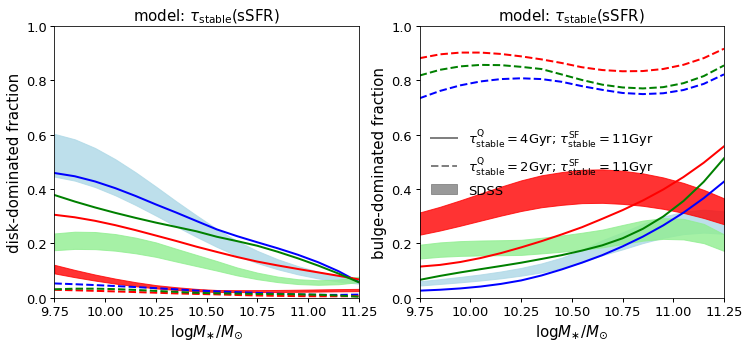

In [35]:
from scipy.signal import savgol_filter

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

a, b = 11, 3

fracerr = 0.15
ylow, yhigh = ((1-fracerr)*savgol_filter(frac_disk_dom_sfs_sdss, a, b), 
               (1+fracerr)*savgol_filter(frac_disk_dom_sfs_sdss, a, b))
__=ax1.fill_between(sm_abscissa_sdss, ylow, yhigh, color='lightblue', alpha=0.8)
ylow, yhigh = ((1-fracerr)*savgol_filter(frac_disk_dom_gv_sdss, a, b), 
               (1+fracerr)*savgol_filter(frac_disk_dom_gv_sdss, a, b))
__=ax1.fill_between(sm_abscissa_sdss, ylow, yhigh, color='lightgreen', alpha=0.8)
ylow, yhigh = ((1-fracerr)*savgol_filter(frac_disk_dom_q_sdss, a, b), 
               (1+fracerr)*savgol_filter(frac_disk_dom_q_sdss, a, b))
__=ax1.fill_between(sm_abscissa_sdss, ylow, yhigh, color='red', alpha=0.8, label='SDSS')

ylow, yhigh = ((1-fracerr)*savgol_filter(frac_bulge_dom_sfs_sdss, a, b), 
               (1+fracerr)*savgol_filter(frac_bulge_dom_sfs_sdss, a, b))
__=ax2.fill_between(sm_abscissa_sdss, ylow, yhigh, color='lightblue', alpha=0.8)
ylow, yhigh = ((1-fracerr)*savgol_filter(frac_bulge_dom_gv_sdss, a, b), 
               (1+fracerr)*savgol_filter(frac_bulge_dom_gv_sdss, a, b))
__=ax2.fill_between(sm_abscissa_sdss, ylow, yhigh, color='lightgreen', alpha=0.8)
ylow, yhigh = ((1-fracerr)*savgol_filter(frac_bulge_dom_q_sdss, a, b), 
               (1+fracerr)*savgol_filter(frac_bulge_dom_q_sdss, a, b))
__=ax2.fill_between(sm_abscissa_sdss, ylow, yhigh, color='red', alpha=0.8, label='SDSS')

xlabel1 = ax1.set_xlabel(r'$\log M_{\ast}/M_{\odot}$', size=15)
xlabel2 = ax2.set_xlabel(r'$\log M_{\ast}/M_{\odot}$', size=15)
ylabel1 = ax1.set_ylabel(r'disk-dominated fraction', size=15)
ylabel2 = ax2.set_ylabel(r'bulge-dominated fraction', size=15)

xmin, xmax = 9.75, 11.25
xlim1 = ax1.set_xlim(xmin, xmax)
xlim2 = ax2.set_xlim(xmin, xmax)
ymin, ymax = 0, 1
ylim1 = ax1.set_ylim(ymin, ymax)
ylim2 = ax2.set_ylim(ymin, ymax)

__=ax1.plot(sm_abscissa_model1, savgol_filter(frac_disk_dom_sfs_model1, a, b), 
            color='blue', lw=2)
__=ax1.plot(sm_abscissa_model1, savgol_filter(frac_disk_dom_q_model1, a, b), 
            color='red', lw=2)
__=ax1.plot(sm_abscissa_model1, savgol_filter(frac_disk_dom_gv_model1, a, b), 
            color='green', lw=2, 
            label=r'$\tau_{\rm stable}^{\rm Q} = 4$Gyr; $\tau_{\rm stable}^{\rm SF} = 11$Gyr')

__=ax2.plot(sm_abscissa_model1, savgol_filter(frac_bulge_dom_sfs_model1, a, b), 
            color='blue', lw=2)
__=ax2.plot(sm_abscissa_model1, savgol_filter(frac_bulge_dom_q_model1, a, b), 
            color='red', lw=2)
__=ax2.plot(sm_abscissa_model1, savgol_filter(frac_bulge_dom_gv_model1, a, b), lw=2, 
            color='green', label=r'$\tau_{\rm stable}^{\rm Q} = 4$Gyr; $\tau_{\rm stable}^{\rm SF} = 11$Gyr')

__=ax1.plot(sm_abscissa_model2, savgol_filter(frac_disk_dom_sfs_model2, a, b), 
            '--', color='blue', lw=2)
__=ax1.plot(sm_abscissa_model2, savgol_filter(frac_disk_dom_q_model2, a, b), 
            '--', color='red', lw=2)
__=ax1.plot(sm_abscissa_model2, savgol_filter(frac_disk_dom_gv_model2, a, b), 
            '--', color='green', lw=2, 
            label=r'$\tau_{\rm stable}^{\rm Q} = 4$Gyr; $\tau_{\rm stable}^{\rm SF} = 11$Gyr')

__=ax2.plot(sm_abscissa_model2, savgol_filter(frac_bulge_dom_sfs_model2, a, b), 
            '--', color='blue', lw=2)
__=ax2.plot(sm_abscissa_model2, savgol_filter(frac_bulge_dom_q_model2, a, b), 
            '--', color='red', lw=2)
__=ax2.plot(sm_abscissa_model2, savgol_filter(frac_bulge_dom_gv_model2, a, b), 
            '--', lw=2, color='green', 
            label=r'$\tau_{\rm stable}^{\rm Q} = 2$Gyr; $\tau_{\rm stable}^{\rm SF} = 11$Gyr')


legend2 = ax2.legend()
for leg in legend2.legendHandles: 
    leg.set_color('gray')

title1 = ax1.set_title(r'model: $\tau_{\rm stable}({\rm sSFR})$')
title2 = ax2.set_title(r'model: $\tau_{\rm stable}({\rm sSFR})$')


In [39]:
chain[-1]

prob1_disrupt,prob2_disrupt,frac_migration,lnprob
float64,float64,float64,float64
0.2571,0.0859,0.4092,-0.0218
